In [1]:
# module importation
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from gurobipy import *
% matplotlib inline

# utilities
from utils import *

# model classes for employees and nodes
from models_v2 import Employee, Node, Task, Home, Unavail
import random as rd

### Implémentation de certaines fonctions d’utilité et de sauvegarde de résultats pour l’affichage

In [3]:
def plot_submap2(employee_list, employee_indices_list, node_list, tasks, unavails, X, L, Z):
    plt.figure(figsize=(cm_to_inch(100), cm_to_inch(100)))

    node_pos = []
    for k in employee_indices_list:
        node_pos.append([employee_list[k].longitude, employee_list[k].latitude])
        rd_color = "#" + ''.join([rd.choice('0123456789ABCDEF') for _ in range(6)])
        plt.scatter([employee_list[k].longitude], [employee_list[k].latitude],
                    label=f"Maison de {employee_list[k].name}", c=rd_color,
                    marker="$(T)$", s=10000)

    #t = len(employee_list)
    all_indexes = employee_indices_list + tasks + unavails

    for k in employee_indices_list:
        for i in all_indexes:
            if (k, i) in L:
                if L[(k, i)] == 1:
                    employee = employee_list[k]
                    node = node_list[i]
                    plt.scatter([node.longitude], [node.latitude], label=f"Pause de {employee.name}", marker="$(P)$",
                                s=5000)

    for i in tasks:
        task = node_list[i]
        node_pos.append([task.longitude, task.latitude])
        plt.scatter([task.longitude], [task.latitude], marker=f"$({task.id})$", s=1000)
        #plt.annotate(task.id,[task.longitude, task.latitude])

    for i in unavails:
        unavail = node_list[i]
        node_pos.append([unavail.longitude, unavail.latitude])
        plt.scatter([unavail.longitude], [unavail.latitude], label="Indisponibilité de " + unavail.employee.name,
                    marker="$(X)$", s=5000)

    number_of_colors = len(employee_list)  # hardcoded
    color = ["#" + ''.join([rd.choice('0123456789ABCDEF') for _ in range(6)])
             for _ in range(number_of_colors)]

    n = len(node_pos)
    for a in range(n):
        for b in range(n):
            i = all_indexes[a]
            j = all_indexes[b]
            if (i, j) in X:
                if i != j and X[(i, j)] == 1:
                    lbl = ""
                    clr = "black"
                    if i in employee_indices_list:  #range(t):

                        lbl = f"{employee_list[Z[j]].name}"
                        clr = color[Z[i]]
                    elif j in employee_indices_list:  #range(t):
                        clr = color[Z[j]]
                    else:
                        clr = color[Z[i]]

                    plt.plot([node_pos[a][0], node_pos[b][0]], [node_pos[a][1], node_pos[b][1]], c=clr, label=lbl)

    plt.legend(prop={'size': 40}, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


def plot_agenda2(employee_list, node_list, tasks, unavails, B, Z, lunch_times):
    N = len(employee_list)
    left, width = 0.1, 20
    bottom, height = 0.1, 0.11

    Table = {k: [left + width / N * k, bottom, width / N - 0.1, height] for k in range(N)}

    Ax = {k: plt.axes(Table[k], frameon=False) for k in range(3)}

    plan = [[] for i in range(N)]

    for t in tasks:
        if t in Z.keys():
            plan[Z[t]].append((B[t], f"tâche {t - N + 1}"))
            plan[Z[t]].append((B[t] + node_list[t].duration, f"tâche {t - N + 1}"))
    for k in range(N):
        plan[k].append((lunch_times[k], f"pause déjeuner"))
        plan[k].append((lunch_times[k] + 60, f"pause déjeuner"))
    for u in unavails:
        plan[Z[u]].append((B[u], f"indisponibilité"))
        plan[Z[u]].append((B[u] + node_list[t].duration, f"indisponibilité"))

    column_labels = [[] for i in range(N)]
    for k in range(N):
        column_labels[k].append("horaires")
        column_labels[k].append(f"{employee_list[k].name}")

    for k in range(N):
        plan[k].sort(key=lambda x: x[0])

        chose = []
        for i in range(0, len(plan[k]) - 1, 2):
            chose.append([f"{time_format(plan[k][i][0])} - {time_format(plan[k][i + 1][0])}", plan[k][i][1]])
        plan[k] = chose

    for k in range(3):
        Ax[k].axis('tight')
        Ax[k].axis('off')
        Ax[k].table(cellText=plan[k], colLabels=column_labels[k])

    plt.show()


def store_result2(target_path, employees, tasks, lunch_times, z, b):
    w, t = len(tasks), len(employees)
    with open(target_path, "w") as f:
        f.write("taskId;performed;employeeName;startTime; \n")
        for i in tasks:
            if i in z.keys():
                f.write(f"T{i - t + 1};1;{employees[z[i]].name};{b[i]};\n")
            else:
                f.write(f"T{i - t + 1};0;;;\n")
        f.write("\n")
        f.write("employeeName;lunchBreakStartTime;\n")
        for k in range(t):
            f.write(f"{employees[k].name};{lunch_times[k]};\n")
    return


def time_format(min):
    return f"{int(min // 60)}:{int(min % 60)}"




### Les répertoires des instances

In [4]:
path_columbia = "./data/InstancesV3/InstanceColumbiaV3.xlsx"
path_romania = "./data/InstancesV3/InstanceRomaniaV3.xlsx"
path_ukraine = "./data/InstancesV3/InstanceUkraineV3.xlsx"

path_australia = "./data/InstancesV2/InstanceAustraliaV2.xlsx"
path_austria = "./data/InstancesV2/InstanceAustriaV2.xlsx"
path_bordeaux = "./data/InstancesV2/InstanceBordeauxV2.xlsx"
path_poland = "./data/InstancesV2/InstancePolandV2.xlsx"
path_spain = "./data/InstancesV2/InstanceSpainV2.xlsx"

path_result_australia = "./results/SolutionAustraliaV2BYV3_cluster.txt"
path_result_austria = "./results/SolutionAustriaV2BYV3_cluster.txt"
path_result_bordeaux = "./results/SolutionBordeauxV2BYV3_cluster.txt"
path_result_poland = "./results/SolutionPolandV2BYV3_cluster.txt"
path_result_spain = "./results/SolutionSpainV2BYV3_cluster.txt"

path_result_columbia = "./results/SolutionColumbiaV3BYV3_cluster.txt"
path_result_ukraine = "./results/SolutionUkrainV3BYV3_cluster.txt"
path_result_romania = "./results/SolutionRomaniaV3BYV3_cluster.txt"

path_to_test = path_australia
path_result = path_result_australia

## Fonction de lecture de fichier

In [5]:
def load_data_from_path(path_to_instance: str):
    # load employee data
    Employee.load_excel(path_to_instance)

    # load node data
    Node.clear_previous_data()
    for cls in [Home, Task, Unavail]:
        cls.load_excel(path_to_instance)
    Node.initialize_distance()  # distance matrix calculation

In [ ]:
load_data_from_path(path_to_test)

## Constantes

In [ ]:
assert Home.count == Employee.count  # each employee should have exactly one home and one lunch
assert Node.count == (Home.count + Task.count + Unavail.count)

# constants
W = Task.count
U = Unavail.count
T = Employee.count
V = Node.count

# indices of employees, homes, lunches, tasks, unavailabilities
employees = list(range(T))
homes = list(range(T))
tasks = list(range(T, T + W))
unavails = list((range(T + W, V)))

nodes = homes + tasks + unavails

## Vérification de certaines propriétés pour s’assurer que le les données sont correctement lus

In [ ]:
# the distance between a node to itself should be 0
assert Node.distance[0, 0] == Node.distance[1, 1] == Node.distance[2, 2] == 0

# the distance matrix should be symmetrical
assert Node.distance[2, 3] == Node.distance[3, 2]
assert Node.distance[5, 1] == Node.distance[1, 5]
print(Employee.list[1].longitude)

-71.0492036


In [ ]:
def open_intervals(i):
    d, f = Node.list[i].opening_time, Node.list[i].closing_time
    task_duration = Node.list[i].duration
    l = [d]
    for s, e in Node.list[i].closed_intervals:
        l.append(s)
        l.append(e)
    l.append(f)
    return [(l[j], l[j + 1]) for j in range(0, len(l), 2) if l[j + 1] - l[j] >= task_duration]

On va utiliser une technique de clustering pour trouver une solution approchée : On va partitionner l'instance en plusieurs sous instances de plus petites tailles qu'on recombinera après.

## on récupère les coordonnées des employés, des tâches et des indisponibilités pour pouvoir faire une partition de l'espace.

In [ ]:
Employee_coord = [[emp.longitude, emp.latitude] for emp in Employee.list]
Task_coord = [[task.longitude, task.latitude] for task in Task.list]
Unavail_coord = [[unavail.longitude, unavail.latitude] for unavail in Unavail.list]
points = Employee_coord + Task_coord + Unavail_coord

assert len(points) == W + T + U

In [ ]:
from sklearn.cluster import SpectralClustering

numb_of_clust = int(
    W / 10) + 1  # on choisi un nombre de cluster qui nous permet d'avoir en moyenne une dizaine de tâches par cluster
clustering = SpectralClustering(n_clusters=numb_of_clust, assign_labels='discretize', random_state=0).fit(
    points)  #W/n_cluster = 10
print(np.unique(clustering.labels_))



[ 0  1  2  3  4  5  6  7  8  9 10]


### On plot le cluster

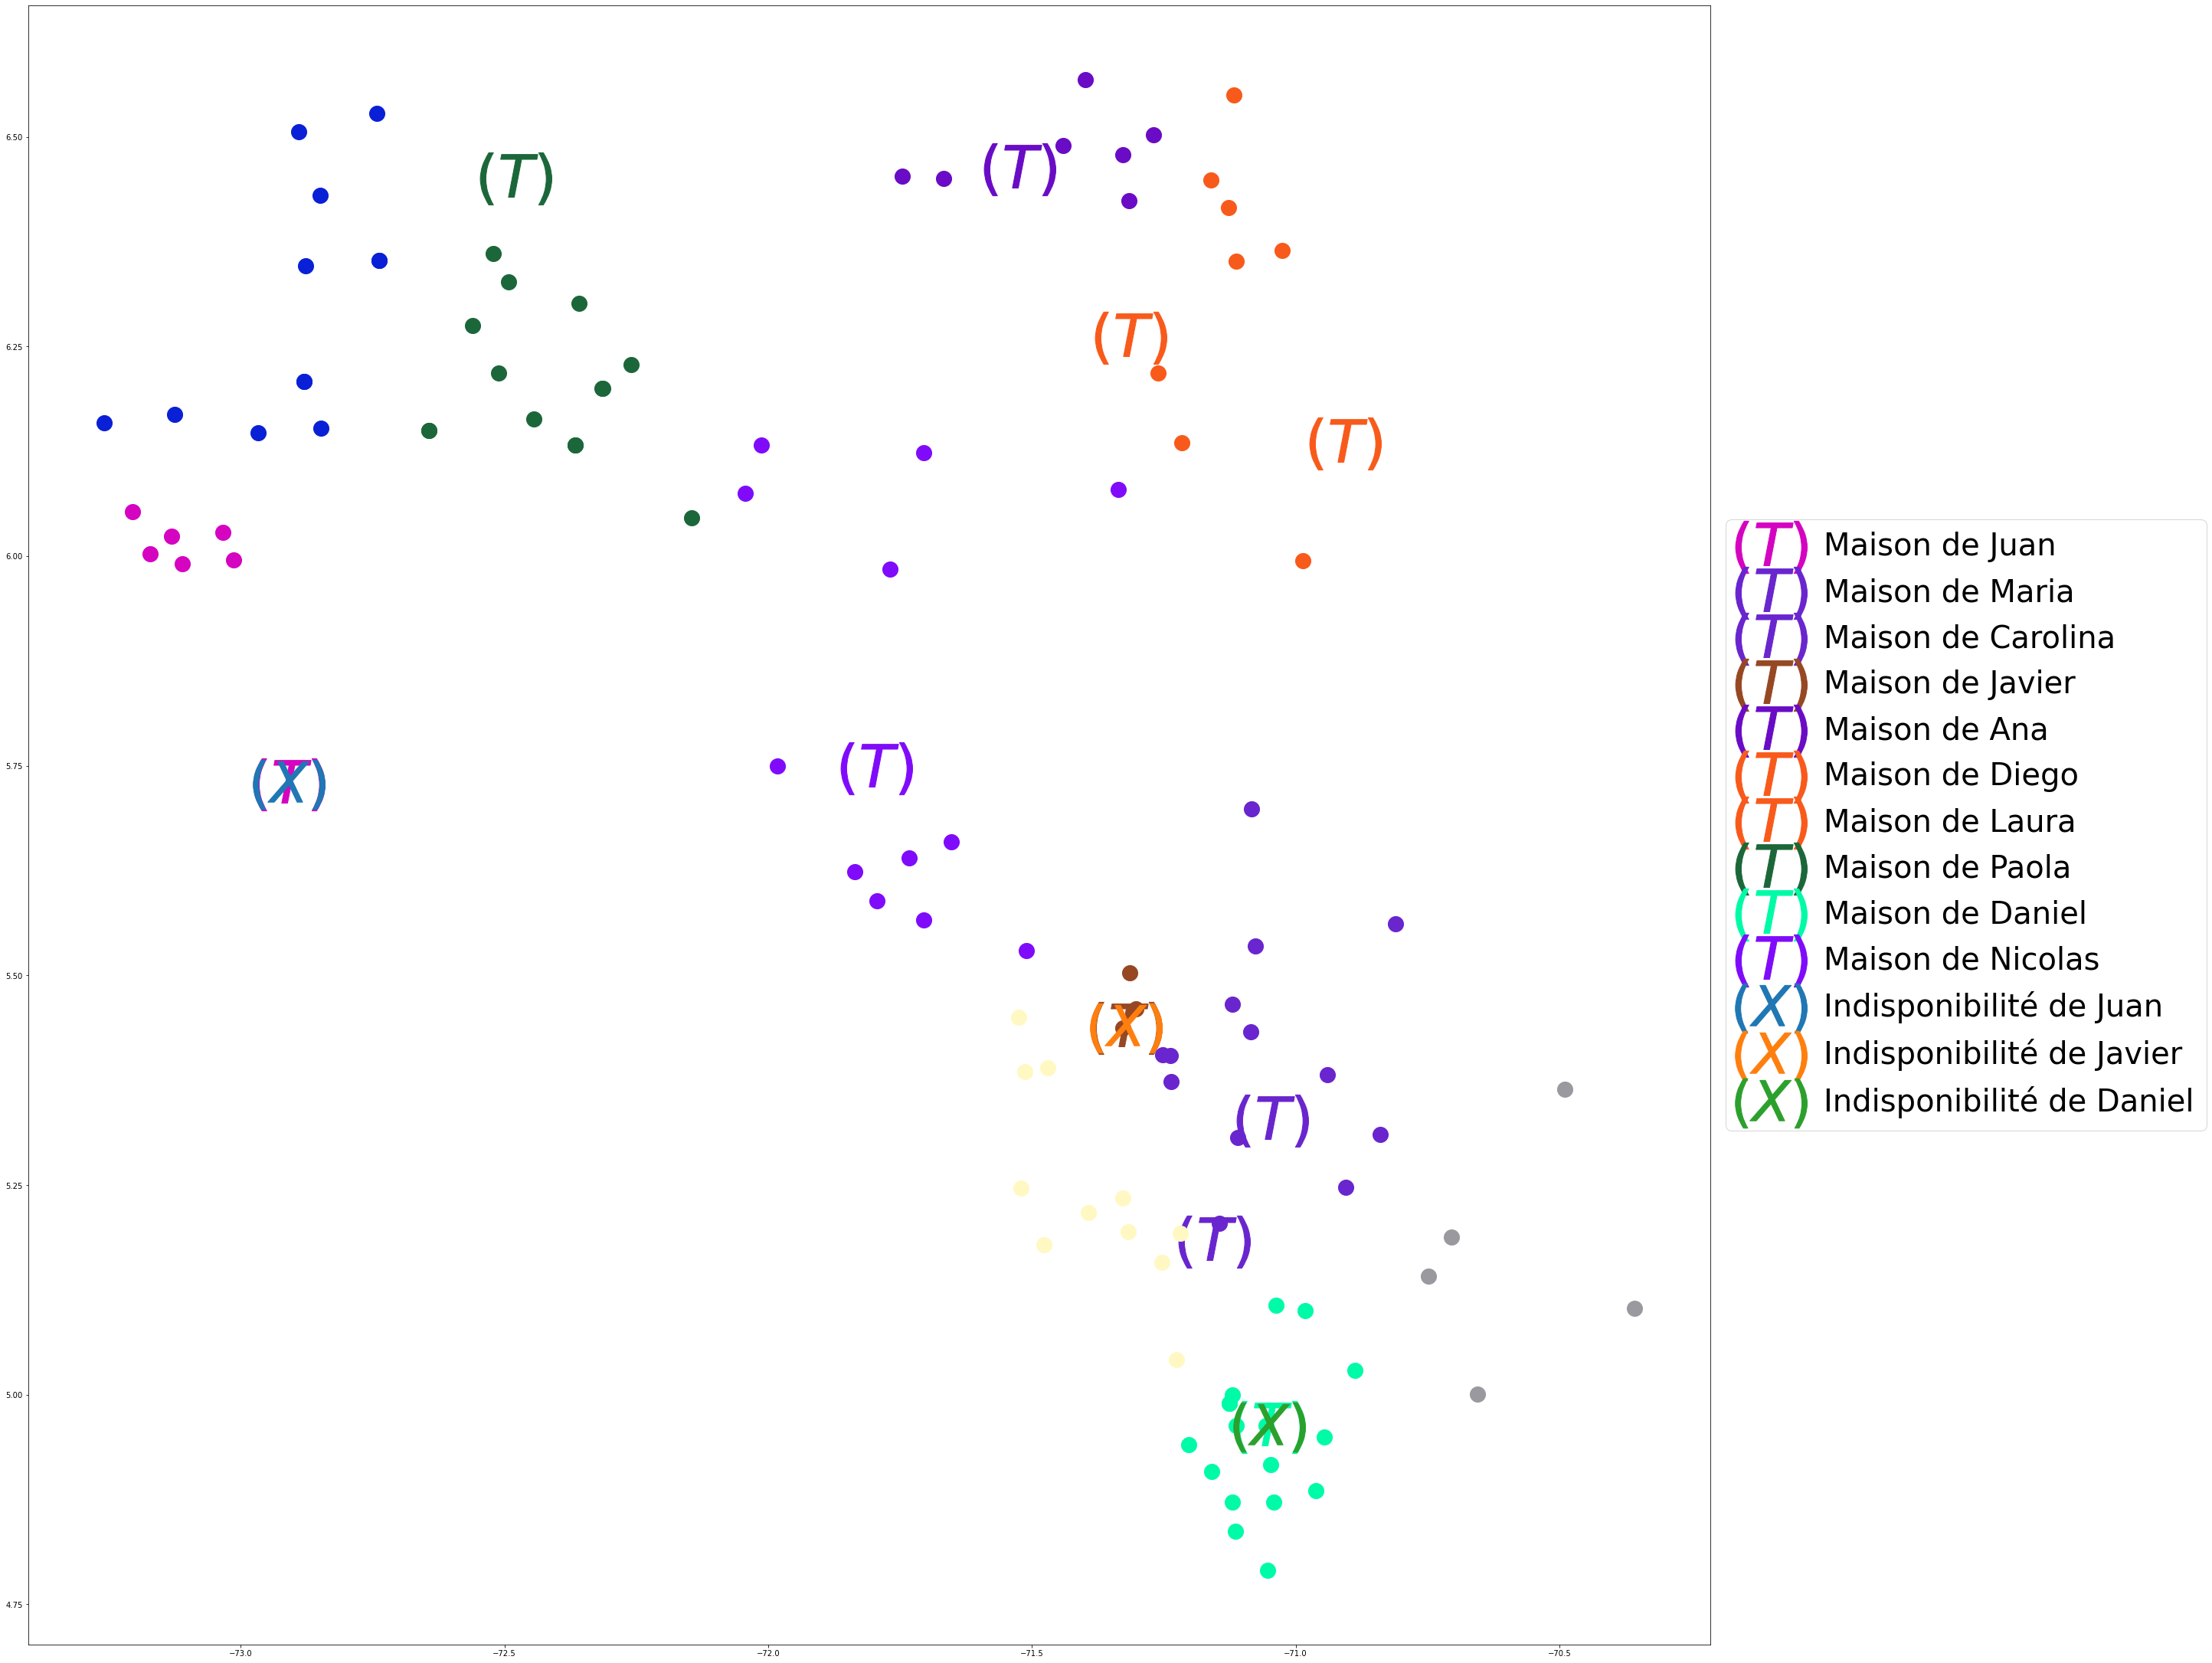

In [ ]:
plt.figure(figsize=(cm_to_inch(100), cm_to_inch(100)))

indice_of_colors = np.unique(clustering.labels_)
n_colors = len(indice_of_colors)
colors = []  #cette liste va contenir les couleur pour plot les clusters
for i in range(0, n_colors):
    rd_color = "#" + ''.join([rd.choice('0123456789ABCDEF') for _ in range(6)])
    colors.append(rd_color)

for i in range(0, T):
    employee = Employee.list[i]
    color = colors[clustering.labels_[i]]
    plt.scatter([employee.longitude], [employee.latitude], label=f"Maison de {employee.name}", c=color, marker="$(T)$",
                s=10000)

for i in range(T, T + len(Task.list)):  #task in Task.list:

    task = Task.list[i - T]

    color = colors[clustering.labels_[i]]

    plt.scatter([task.longitude], [task.latitude], c=color, s=400)

for unavail in Unavail.list:
    plt.scatter([unavail.longitude], [unavail.latitude], label="Indisponibilité de " + unavail.employee.name,
                marker="$(X)$", s=10000)
plt.legend(prop={'size': 40}, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [ ]:
print(np.unique(clustering.labels_))  #on affiche les labels des clusters
for lab in np.unique(clustering.labels_):
    if len([home for home in homes if clustering.labels_[home] == lab]) > 0:
        print(lab)
        # on récupère les indices des maisons, des taches et des indisponinbilités du cluster
        homes_clust = [home for home in homes if clustering.labels_[home] == lab]
        print(homes_clust)
        tasks_clust = [task for task in tasks if clustering.labels_[task] == lab]
        unavails_clust = [unavail for unavail in unavails if clustering.labels_[unavail] == lab]

        nodes_clust = homes_clust + tasks_clust + unavails_clust



[ 0  1  2  3  4  5  6  7  8  9 10]
0
[0]
1
[8]
2
[4]
3
[1, 2]
4
[7]
8
[3]
9
[5, 6]
10
[9]


## Les contraintes imposées à chaque cluster/sous-graphe sont similaires à celles dans la phase 2

In [ ]:
dist = []
task_time = []
Z = {}
lunch_times = {}
B_res = {}
X_res = {}
L_res = {}  # ces dictionnaires serviront à stocker les valeurs de X, L, B de chaque instance
for lab in np.unique(clustering.labels_):
    if len([home for home in homes if
            clustering.labels_[home] == lab]) > 0:  #s'il y a un employé dans le cluster, la liste n'est pas vide

        # les listes homes_clust, tasks_clust et unavails_clust contiennent les indices des employés, des taches et des indisponibilités présent dans le cluster
        #comme les indisponibilités ont toujours lieu à la maison des employés, il n'y a pas de probèmes
        homes_clust = [home for home in homes if clustering.labels_[home] == lab]

        tasks_clust = [task for task in tasks if clustering.labels_[task] == lab]
        unavails_clust = [unavail for unavail in unavails if clustering.labels_[unavail] == lab]

        nodes_clust = homes_clust + tasks_clust + unavails_clust
        m = Model("DB")

        # an arbitrarily big variable
        M = 1000000

        # decision variables
        X = {(i, j): m.addVar(vtype=GRB.BINARY, name=f'x{i}_{j}') for i in nodes_clust for j in nodes_clust if i != j}
        Y = {(k, i): m.addVar(vtype=GRB.BINARY, name=f'y{k}_{i}') for k in homes_clust for i in nodes_clust}
        B = {i: m.addVar(vtype=GRB.INTEGER, name=f'b{i}', lb=0, ub=24 * 60) for i in nodes_clust}
        L = {(k, i): m.addVar(vtype=GRB.BINARY) for k in homes_clust for i in nodes_clust}
        P = {k: m.addVar(vtype=GRB.INTEGER, lb=12 * 60, ub=13 * 60) for k in homes_clust}
        t = {(i, l): m.addVar(vtype=GRB.BINARY, name=f't{l}') for i in tasks_clust for l in
             range(len(open_intervals(i)))}

        # constraints

        # C1
        for i in nodes_clust:
            m.addConstr(quicksum([X[(i, j)] for j in nodes_clust if i != j]) == quicksum(
                [X[(j, i)] for j in nodes_clust if i != j]))

        # C2
        for j in homes_clust + tasks_clust:
            m.addConstr(quicksum([X[(i, j)] for i in nodes_clust if i != j]) <= 1)

        # C3_a
        for j in unavails_clust:
            m.addConstr(quicksum([X[(i, j)] for i in nodes_clust if i != j]) == 1)

        # C3_b
        for i in homes_clust + unavails_clust:
            employee = Node.list[i].employee
            for k in homes_clust:
                if employee == Employee.list[k]:
                    m.addConstr(Y[(k, i)] == 1)
                else:
                    m.addConstr(Y[(k, i)] == 0)

        # C4
        for i in nodes_clust:
            for j in nodes_clust:
                if i != j:
                    for k in homes_clust:
                        m.addConstr(Y[(k, i)] <= Y[(k, j)] + 1 - X[(i, j)])
                        m.addConstr(Y[(k, i)] >= Y[(k, j)] - 1 + X[(i, j)])

        # C5
        for i in tasks_clust:
            m.addConstr(B[i] >= Node.list[i].opening_time)
            m.addConstr(Node.list[i].duration + B[i] <= Node.list[i].closing_time)

        # C6_a
        for k in homes_clust:
            m.addConstr(B[k] >= Employee.list[k].start_time)

        # C6_b
        for i in unavails_clust:
            m.addConstr(B[i] == Node.list[i].opening_time)

        # C7
        for i in tasks_clust:
            intervals = open_intervals(i)
            m.addConstr(quicksum([t[(i, l)] for l in range(len(intervals))]) == quicksum(
                [X[(i, j)] for j in nodes_clust if i != j]))

            for l in range(len(intervals)):
                start, end = intervals[l]
                m.addConstr(B[i] >= start - (1 - t[(i, l)]) * M)
                m.addConstr(B[i] + Node.list[i].duration <= end + (1 - t[(i, l)]) * M)

        # C8
        for k in homes_clust:
            m.addConstr(B[k] <= P[k])
            for i in tasks_clust + unavails_clust:
                m.addConstr(B[k] + ceil(Node.distance[k, i] / Employee.speed) - (1 - X[(k, i)]) * M <= B[i])
                m.addConstr(
                    P[k] + 60 + ceil(Node.distance[k, i] / Employee.speed) - (2 - X[(k, i)] - L[(k, k)]) * M <= B[i])

            # C9
        for k in homes_clust:
            for i in tasks_clust + unavails_clust:
                m.addConstr(B[i] + Node.list[i].duration + ceil(Node.distance[i, k] / Employee.speed) <= Employee.list[
                    k].end_time + M * (1 - X[(i, k)]))
                m.addConstr(B[i] + Node.list[i].duration <= P[k] + M * (2 - L[(k, i)] - X[(i, k)]))
                m.addConstr(
                    P[k] + 60 + Node.list[i].duration + ceil(Node.distance[i, k] / Employee.speed) <= Employee.list[
                        k].end_time + M * (2 - X[(i, k)] - L[(k, i)]))

            # C10_a
        for k in homes_clust:
            m.addConstr(quicksum([L[(k, i)] for i in nodes_clust]) == 1)

        # C10_b
        for k in homes_clust:
            for i in nodes_clust:
                m.addConstr(Y[(k, i)] >= L[(k, i)])

        # C11
        for i in tasks_clust + unavails_clust:
            m.addConstr(
                quicksum([Y[(k, i)] for k in homes_clust]) <= quicksum([X[(j, i)] for j in nodes_clust if j != i]))

        # C12
        for i in tasks_clust + unavails_clust:
            for j in tasks_clust + unavails_clust:
                if i != j:
                    pause_en_i = quicksum([L[(k, i)] for k in homes_clust])
                    m.addConstr(
                        B[i] + Node.list[i].duration + ceil(Node.distance[i, j] / Employee.speed) <= B[j] + M * (
                                1 - X[(i, j)]))
                    m.addConstr(B[i] + Node.list[i].duration <= P[k] + M * (2 - X[(i, j)] - pause_en_i))
                    m.addConstr(
                        P[k] + 60 + Node.list[i].duration + ceil(Node.distance[i, j] / Employee.speed) <= B[j] + M * (
                                2 - X[(i, j)] - pause_en_i))

        # C13
        for k in homes_clust:
            for i in tasks_clust:
                m.addConstr(Employee.list[k].level >= Node.list[i].level - M * (1 - Y[(k, i)]))

        obj = quicksum([X[(i, j)] * Node.list[j].duration for i in nodes_clust for j in tasks_clust if i != j])
        total_dist = quicksum([Node.distance[i, j] * X[(i, j)] for i in nodes_clust for j in nodes_clust if i != j])
        m.setParam('TimeLimit', 15 * len(
            homes_clust))  # on accorde pour chaque cluster un temps de résolution qui est proportionnel au nombre d'employé dans le cluster.
        m.setObjective(obj - total_dist / 1000, GRB.MAXIMIZE)

        m.params.outputflag = 0

        m.update()

        m.optimize()
        if m.Status == 3:
            print("pas de solutions")
        dist.append(total_dist.getValue())
        task_time.append(obj.getValue())

        for i in nodes_clust:
            for k in homes_clust:
                if Y[(k, i)].x == 1:
                    Z[i] = k
        for i in nodes_clust:
            for j in nodes_clust:
                if i != j:
                    X_res[(i, j)] = X[(i, j)].x
        for k in homes_clust:
            for i in nodes_clust:
                L_res[(k, i)] = L[(k, i)].x
        for k in homes_clust:
            for i in nodes_clust:
                if L[(k, i)].x == 1:
                    if Node.list[i].node_type != 'home':
                        lunch_times[k] = B[i].x + Node.list[i].duration
                    else:
                        lunch_times[k] = B[i].x
        for i in nodes_clust:
            B_res[i] = B[i].x

plot_submap2(Employee.list, homes, Node.list, tasks, unavails, X_res, L_res, Z)
#plot_agenda2(Employee.list, Node.list,tasks,unavails,B_res,Z,lunch_times)

Set parameter TimeLimit to value 15
Set parameter TimeLimit to value 15
Set parameter TimeLimit to value 15
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 15


In [ ]:
print('Temps totale des tâches effectuées : {} min \n Distance totale : {} m'.format(sum(task_time), sum(dist)))
print(sum(dist))
print(sum(task_time))

Temps totale des tâches effectuées : 3473.0 min 
 Distance totale : 957075.9937287408 m
957075.9937287408
3473.0


## Savegarde de Résultats

In [ ]:
store_result2(path_result, Employee.list, tasks, lunch_times, Z, B_res)